In [115]:
import numpy as np 
import itertools
import pandas as pd 
import torch
import networkx as nx 
from matplotlib import pyplot as plt
import math 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.cluster import KMeans
from torch_geometric.nn import VGAE, GCNConv, SAGEConv, GraphConv
import copy 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import os 

#from pympler import asizeof
#from tqdm import tqdm 

In [116]:
class GLMGraph:
    """
    Generate a Graph with conditional edge distribution modeled via GLM's.
    Graph should have: x, y: Node features and target
    edge_index: all edges in the graph
    pos_edge_label_index: A subset of edge index (typically half)
    neg_edge_label_index: A subset of all non-existing edges (same length as pos_edge_label_index)
    No Edge Attributes considered.
    """

    def __init__(self, n_nodes: int):

        self.Nx = None  # a NetworkX representation
        self.DataObject = None 
        
        self.n_nodes = n_nodes
        self.n_edge_permutations = int((self.n_nodes * (self.n_nodes - 1)) / 2)  # all permutations

        self.num_features = None
        self.mixture_comp_labels = None # (gaussian) cluster-component label 
        
        self.cat_features = None # one-hot-encoded community matrix 
        self.community_labels = None # k-mean assigned labels 
        
        self.x = None
        self.y = None
        self.long_data = None

        self.edge_index = None
        self.pos_edge_label_index = None
        self.neg_edge_label_index = None

    def add_num_features(self, n_c: int, mu: list, sigma: list, w: list):
        """
        :param n_c: number of cluster components
        :param mu: list of tuples corresponding to
        num of features (tuple-length) and number of components (list-length)
        :param sigma: Covariance matrix
        :param w: mixture weights
        :return: None

        Add numeric features. Only used within the class. The X values for each component are sorted (asc. order)
        So indexing is straightforward (beneficial for Adj. Matrix?)
        """
        assert len(mu) == len(sigma) == len(w), "Different dimensions chosen for mus, sigma, w. "

        # Sample from Gaussian-Mixture Model: 
        component_labels = np.sort(
            np.random.choice(n_c, size=n_nodes, p=w)
        )
        data = np.array([np.random.multivariate_normal(mu[label],
                                                       sigma[label])
                            for label in component_labels])
        
        self.num_features = data
        self.mixture_comp_labels = component_labels
        

    def add_community(self, k: int):
        """
        :param k: k communities
        :return: None
        """
        assert self.num_features is not None, "num_features must be instantiated."
        kmeans = KMeans(n_clusters=k, n_init=1, tol=0.1).fit(self.num_features)
        
        self.community_labels = np.array(kmeans.labels_)
        self.cat_features = pd.get_dummies(kmeans.labels_).to_numpy(dtype=np.float16)

    def set_x(self, ignore_cat=True):
        """
        Set the feature-matrix for the Graph.
        :param ignore_cat: Only numeric values are used. 
        """
        if self.cat_features is not None and ignore_cat == False:
            self.x = np.concatenate((self.num_features, self.cat_features), axis=1)
        else:
            self.x = self.num_features

    def set_y(self, theta: list, eps: float, task="binary", treshhold=0.5):
        """
        Only relevant for Graph-regression or Node classification tasks.
        :param theta: model params (no intercept)
        :param eps: variance of linear relationship
        :param task: if y should be "binary","multiclass" or "regression"
        :param treshhold: float or list of uniform(0,1) numbers, 
        :return: None
        """
        if task == "regression":
            y = np.dot(self.x, theta) + np.random.normal(0, eps, self.n_nodes)
            
        if task == "binary":
            lin_rel = np.dot(self.x, theta) + np.random.normal(0, eps, self.n_nodes)
            y = (1 / (1 + np.exp(-lin_rel))) >= treshhold
        
        if task == "multiclass":
            pass
        
        self.y = y.astype(float)

    def set_connections(self, intercept, theta, eps, ignore_cat=True):
        """
        :param intercept: Base connectivity, should center the log_odds around 0
        :param theta: Model params (similar nodes should have higher coefficients)
        :param eps: model variance
        :param ignore_cat: if True: no explanatory information from communities to edge-connections 
        """
        n_rows = self.n_edge_permutations
        m_num = self.num_features.shape[1]
        m_cat = 1 # self.community_labels.shape[1] # should always be 1 
        
        if self.cat_features is not None and ignore_cat == False:
            m_cols = m_num + m_cat
            long = np.zeros((n_rows, m_cols)) #, dtype=np.float64)
            
            for i in range(m_num):
                xi_pairs = list(itertools.combinations(self.x[:, i], 2))
                xi_delta = [math.sqrt((pair[0] - pair[1])**2) for pair in xi_pairs] #euclidean distance
                long[:, i] = xi_delta
            
            xi_pairs = list(itertools.combinations(self.community_labels, 2)) # self.x[:, ip]
            xi_same = [float(pair[0] == pair[1]) for pair in xi_pairs] #euclidean distance
            long[:, m_num] = xi_same # due to zero indexing 
            
        else:
            m_cols = self.num_features.shape[1]
            long = np.zeros((n_rows, m_cols))

            for i in range(m_cols):
                xi_pairs = list(itertools.combinations(self.x[:, i], 2))
                xi_delta = [math.sqrt((pair[0] - pair[1])**2) for pair in xi_pairs] #euclidean distance
                long[:, i] = xi_delta

        df_long = pd.DataFrame(long)
        df_long.index = list(itertools.combinations(list(range(self.n_nodes)), 2))

        log_odds = intercept + np.dot(df_long, theta) + np.random.normal(0, eps, n_rows)
        df_long["edge_prob"] = (1 / (1 + np.exp(-log_odds))) # - 0.001
        df_long.loc[df_long['edge_prob'] == 1, 'edge_prob'] = 0.998 # avoid zero division error
        df_long.loc[df_long['edge_prob'] == 0, 'edge_prob'] = 0.001

        self.long_data = df_long

    def set_Nx(self, treshhold):
        """
        :param treshhold: a list of uniform numbers (0,1) or a float
        :return: None
        example of self.edge_index:
        tensor([[ 1,  1,  1, 48],
                [ 2,  9, 10, 49]])
        """

        node_idx = list(range(self.n_nodes))
        G = nx.Graph()
        G.add_nodes_from(node_idx)
        
        # for i, community in enumerate(self.community_labels):
        #    G.nodes[i]['community'] = community

        G.add_edges_from(self.long_data[self.long_data['edge_prob'] > treshhold].index)
        edge_list = list(G.edges())

        self.Nx = G
        self.edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

    def sample_train_edge_labels(self, size: int = None):
        """
        :param size: sample size of pos and neg edges
        Throws an error when not enough negative connections are established.
        """
        assert self.edge_index is not None, "No edge_indices set."

        if not size:
            size = self.n_nodes // 2

        # Positive:
        sidx_pos = np.random.choice(range(self.edge_index.shape[1]), size=size)
        self.pos_edge_label_index = self.edge_index[:, sidx_pos]

        # Negative:
        tuple_pos = set([(int(self.edge_index[0][i]),
                          int(self.edge_index[1][i]))
                         for i in range(self.edge_index.shape[1])])  # Make set of all connected node tuples
        all_permutations = set(list(itertools.combinations(list(range(self.n_nodes)), 2)))

        samp_space = np.array(list(all_permutations - tuple_pos)).T
        # print(samp_space.shape[1] + len(tuple_pos) == len(all_permutations)) # -> True
        assert samp_space.shape[1] >= size, \
            (f"Not enough negative connections to sample from. possible: {samp_space.shape[1]} | "
             f"required:{size}")

        sidx_neg = np.random.choice(range(samp_space.shape[1]), size=size)
        self.neg_edge_label_index = torch.tensor(
            samp_space[:, sidx_neg]
        )

    def set_Data_object(self):
        data = Data(x=torch.tensor(self.x, dtype=torch.float32), 
                    edge_index=self.edge_index, # allready a tensor 
                    y = torch.tensor(self.y, dtype=torch.float32),
                    pos_edge_label_index=self.pos_edge_label_index, # allready a tensor 
                    neg_edge_label_index=self.neg_edge_label_index) # allready a tensor 
        
        self.DataObject = data

    def plot_connection_details(self):
        log_odds = log_odds = np.log(self.long_data["edge_prob"] / (1 - self.long_data["edge_prob"]))

        plt.subplot(1, 2, 1)
        plt.hist(log_odds, bins=20, edgecolor='black')
        plt.title("Distribution of generated log-odds")
        plt.xlabel('Log-odds')
        plt.ylabel('Frequency')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        self.long_data["edge_prob"].hist(bins=100)
        plt.title('Histogram of Probability')
        plt.xlabel('Connection Probs')

        plt.tight_layout()
        plt.show()
    
    def plot_2d(self, main="Graph"):
        """
        Plot the Graph, with communities/target-class up to 5 categories. 
        """
        # assert self.num_features.shape[1] == 2, "Needs 2 numeric features."

        target = self.mixture_comp_labels
        
        G = self.Nx
        node_idx = list(range(self.n_nodes))
        
        # Assign 2D position to each node based on features
        for i in node_idx:
            G.nodes[i]['pos'] = self.num_features[i]
            G.nodes[i]['category'] = self.community_labels[i]
            G.nodes[i]['target'] = target[i]
        
        pos = {node: data['pos'] for node, data in G.nodes(data=True)}
        color_map = {0: 'purple', 1: 'darkgreen', 2: 'gold', 3: "black", 4:"silver"} 
        shape_map = {0: 'x', 1: 'o', 2: "d", 3: "D", 4: "<"} #
        
        plt.figure(figsize=(10, 10))
        for shape in shape_map:
            nodelist = [node for node in G.nodes() if G.nodes[node]['target'] == shape]
            node_colors = [color_map[G.nodes[node]['category']] for node in nodelist]
            nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=node_colors, node_size=20, node_shape=shape_map[shape])
        
        nx.draw_networkx_edges(G, pos, edge_color='gray', width=.5, alpha=.1)
        
        plt.title(main)
        plt.axis('off')  
        plt.show()
        
    def clear_memory(self, all=False):
        """
        Should only be used, when Nx and Data object haven been constructed. 
        """
    
        if all:
            self.community_labels = None
            self.num_features = None
            
        self.n_edge_permutations = None
        self.cat_features = None # one-hot-encoded community 
        
        self.x = None
        self.y = None
        self.long_data = None

        self.edge_index = None
        self.pos_edge_label_index = None
        self.neg_edge_label_index = None
        
        
    def get_graph_statistics(self):
        pass    

### Generate Graphs

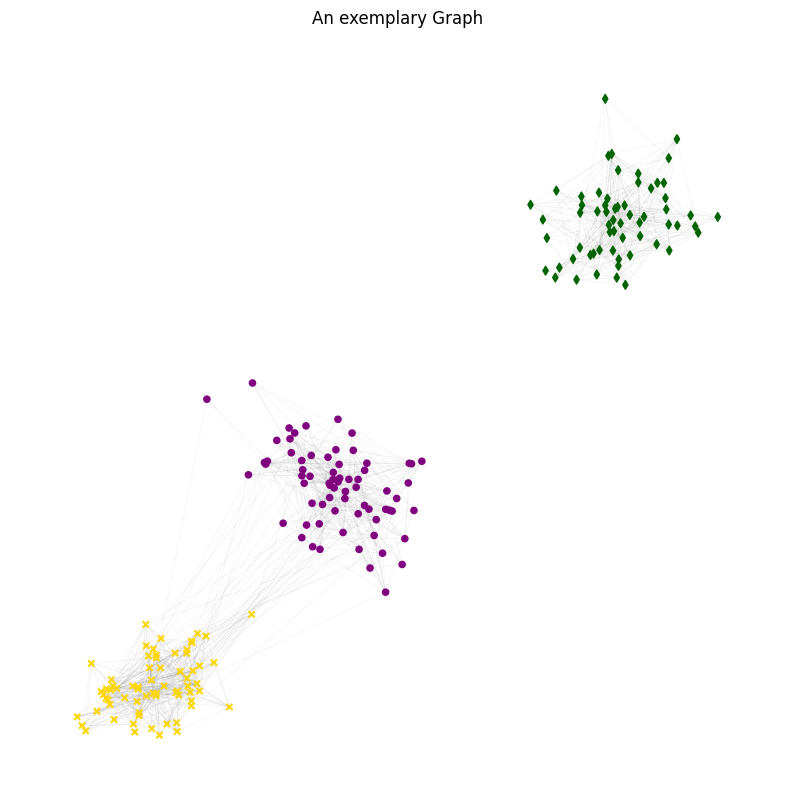

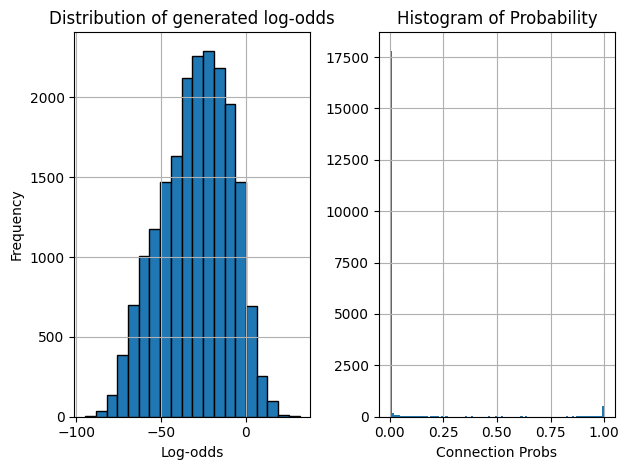

In [228]:
# ************************************************
# ********* Set Distribution Parameters: *********
# ************************************************
# I.e. Scenario:

means = [(-3.5, -4),
         (0, .5),
         (5, 6.5)]

covariances = [np.array([[0.5, 0.3],
                         [0.3, 0.5]]),
               np.array([[0.8, -0.2],
                         [-0.2, 0.8]]),
               np.array([[0.6, 0.1],
                         [0.1, 0.6]])]

weights = [0.3, 0.4, 0.3]

k = 3
y_theta = [1.5, 3] # + [1 for _ in range(k)]

c_intercept = -5
c_theta = np.array([-3, -2.5])#, np.log(10)])
n_nodes = 200

# Set MC-variance: 

y_eps = 3
c_eps = 10
R = 20 # Number of MC-runs

igncat = True

def gen_graph(n_nodes, clear=True, th=.5):
    """ Adjusted to workflow order"""
    gglm = GLMGraph(n_nodes)
    
    gglm.add_num_features(n_c=3, mu=means, sigma=covariances, w=weights)
    gglm.add_community(k)
    gglm.set_x(ignore_cat=igncat)

    gglm.set_y(y_theta, y_eps, task="binary")
    
    gglm.set_connections(c_intercept, c_theta, c_eps, ignore_cat=igncat)
    if not th:
        th = np.random.rand(gglm.n_edge_permutations) #treshhold
    
    gglm.set_Nx(th)
    
    gglm.sample_train_edge_labels()
    gglm.set_Data_object()
    
    if clear:
        gglm.clear_memory() # leaves only Nx and DataObject 

    return gglm

sampG = gen_graph(n_nodes, False)
sampG.plot_2d("An exemplary Graph")
sampG.plot_connection_details()

In [229]:
train_data_list, val_data_list, test_data_list = [], [], []

n_train = math.floor(0.8 * R)
n_test = math.floor(0.15 * R)
n_val = math.floor(0.05 * R)

split_select = np.concatenate((np.repeat(1, n_train),
                               np.repeat(2, n_test),
                               np.repeat(3, n_val)))


# Assign generated graph to test, train or val
while split_select.size > 0:
    graph = gen_graph(n_nodes)
    random_draw = np.random.randint(0, split_select.size)
    x = split_select[random_draw]
    if x == 1:
        train_data_list.append(graph)
    if x == 2:
        test_data_list.append(graph)
    if x == 3:
        val_data_list.append(graph)
        
    split_select = np.delete(split_select, random_draw)

## Encoders 

https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/autoencoder.html#VGAE.kl_loss 

In [230]:
class VGCNEncoderBase(torch.nn.Module):
    """
    Standard inner-product Decoder by default. 
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        """
        :param x: Node features 
        :param edge_index: connection information
        :return: a tuple of 2 tensors of size out_channel
        """
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index) # ([16,16])


In [231]:
class VGCNEncoder2(torch.nn.Module):
    """
    Standard inner-product Decoder by default. 
    """
    def __init__(self, in_channels, out_channels,dr):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)
        self.batch_norm1 = torch.nn.BatchNorm1d(2 * out_channels)
        self.dropout = torch.nn.Dropout(p=dr) 

    def forward(self, x, edge_index):
        """
        :param x: Node features 
        :param edge_index: connection information
        :return: a tuple of 2 tensors of size out_channel
        """
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        
        return mu, logstd  # ([16,16])

### Train VGAE

In [233]:
in_channels = 2
out_channels, lr, dr =  24, 1e-2, .1
n_epochs, alpha, batch_size = 50, .05, 1

# Parameters of VGAE: Encoder (with its parameters) and optional(!) decoder.
# self.decoder = InnerProductDecoder() if decoder is None else decoder.

# Here the model is specified: 
model = VGAE(encoder=VGCNEncoderBase(in_channels, out_channels),
             decoder=None)
#model = VGAE(encoder=VGCNEncoder2(in_channels, out_channels, dr=.33))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

experiment_name = f"ex{1}"
log_dir = os.path.join("experiments", experiment_name)
writer = SummaryWriter(log_dir)

hparams = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'learning_rate': lr,
    'epochs': n_epochs,
    'alpha': alpha,
    'batch_size': batch_size,
    'drop_out':dr
}

# Log the model architecture as text
model_architecture = str(model)
writer.add_text('Model/Architecture', model_architecture)

def one_train_iter(alpha:float = alpha):
    """
    :param alpha: mixture weight for influence of KL-loss. 
    :return: Epoch Loss, averaged over all Batches.  
    Might set a seed, due to randomness in re-parametrize 
    """
    model.train()
    loss_all = 0
 
    for data in train_loader:
        optimizer.zero_grad()
        # "model" is an instance of the VGAE class.
        # The layers and forward method are passed as inputs to VGAE().

        z = model.encode(data.x, data.edge_index) # only one tensor due to re-parametrize (see source code)
        
        # reconstruction loss: use both positive and negative samples (nodes with and without edges)
        # since we want to predict both outcomes: edge or no edge
        loss = model.recon_loss(z, data.pos_edge_label_index, data.neg_edge_label_index)
        loss = (1- alpha) * loss + alpha * model.kl_loss() 
        loss.backward()
        loss_all += data.y.size(0) * float(loss) # (variable) batch size * loss
        optimizer.step()
        
    avg_loss = loss_all / len(train_loader.dataset)
    print(avg_loss)
    
    return avg_loss

@torch.no_grad()
def validate(loader):
    model.eval()
    auc_all, ap_all = 0, 0

    for data in loader:
        z = model.encode(data.x, data.edge_index)
        auc, ap = model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)
        auc_all += data.y.size(0) * float(auc) # Scale by batch_size 
        ap_all += data.y.size(0) * float(ap) # Scale by batch_size 
    return auc_all / len(val_loader.dataset), ap_all / len(val_loader.dataset)


train_loader = DataLoader([graph.DataObject for graph in train_data_list], batch_size=batch_size, shuffle=True)
val_loader = DataLoader([graph.DataObject for graph in val_data_list], batch_size=batch_size, shuffle=True)


for epoch in range(1, n_epochs + 1):
    loss = one_train_iter(alpha=.05) 
    auc, ap = validate(val_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, AP: {ap:.4f}')
    
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('AUC/val', auc, epoch)
    writer.add_scalar('AP/val', ap, epoch)

writer.close()

# tensorboard --logdir=experiments

132189.4738316536
Epoch: 001, Loss: 132189.4738, AUC: 156.6600, AP: 142.0654
549.336376786232
Epoch: 002, Loss: 549.3364, AUC: 168.1400, AP: 162.4339
467.46132373809814
Epoch: 003, Loss: 467.4613, AUC: 172.7600, AP: 152.2034
447.3444938659668
Epoch: 004, Loss: 447.3445, AUC: 175.5200, AP: 162.1711
433.2816079258919
Epoch: 005, Loss: 433.2816, AUC: 174.7200, AP: 156.2748
413.9547675848007
Epoch: 006, Loss: 413.9548, AUC: 174.9400, AP: 156.8879
404.63996678590775
Epoch: 007, Loss: 404.6400, AUC: 175.9200, AP: 166.9680
400.5062997341156
Epoch: 008, Loss: 400.5063, AUC: 174.1000, AP: 165.0132
390.63569605350494
Epoch: 009, Loss: 390.6357, AUC: 175.9200, AP: 165.2052
396.4409753680229
Epoch: 010, Loss: 396.4410, AUC: 176.9000, AP: 167.9917
400.414876639843
Epoch: 011, Loss: 400.4149, AUC: 175.9200, AP: 162.9533
389.0334576368332
Epoch: 012, Loss: 389.0335, AUC: 174.4800, AP: 160.6654
396.60860896110535
Epoch: 013, Loss: 396.6086, AUC: 173.3600, AP: 155.3643
389.7420182824135
Epoch: 014, Los

## Sample new Graphs

sampling random numbers from an N(0,1) distribution for $z$ will not work, since only inner products between random numbers 
will happen while X information is not incorporated. 

In [250]:
def get_stats(graph):
    edges_per_node = nx.adjacency_matrix(graph.Nx).sum(axis=0)
    stats_df = pd.DataFrame({"edges": edges_per_node,
                         "community": graph.community_labels})
    return stats_df


@torch.no_grad()
def sample_from_test(graph, th=None):
    """
    :param graph: A GGLM with a DataObject instantiated
    Don't overwrite Information from Graph, so it can be further used. 
    """
    base_stats = get_stats(graph)
    #graph.plot_2d("Orginal")
    
    data = graph.DataObject
    model.eval()
    z = model.encode(data.x, data.edge_index)
    if th:
        A = model.decoder.forward_all(z, sigmoid=True).detach().numpy()
        print("min: ", A.min(),"max: ", A.max())
        plt.hist(np.unique(np.round(A, 4)), bins=40)
        plt.show()
        A = A > th
    else:
        th = np.random.uniform(low=0.0, high=1.0, size=(200, 200))
        A = model.decoder.forward_all(z, sigmoid=True).detach().numpy() 
        A = A > th
        
    A[np.arange(200), np.arange(200)] = 0 # remove self connection loops (along diag) 
    
    # Copy Graph to rewire edges: 
    new_graph = copy.deepcopy(graph)
    new_graph.Nx.clear_edges()
    indices = np.nonzero(A)
    edges = zip(indices[0], indices[1])
    
    new_graph.Nx.add_edges_from(edges)
    synth_stats = get_stats(new_graph)
    #graph.plot_2d("Synthetic")
    
    return base_stats, synth_stats


min:  0.044720486 max:  0.99972767


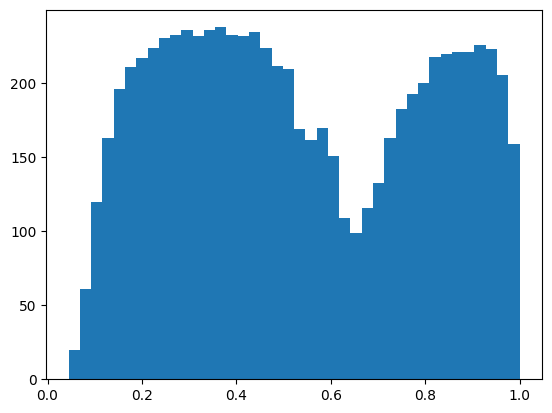

In [255]:
base_stats, synth_stats = sample_from_test(graph=gen_graph(200),
                                           th=0.6)

**Alphas should not be too large, in order to ensure a wide spread of connection probabilities**

               edges
community           
0           9.016949
1          12.988095
2          10.894737
               edges
community           
0          59.847458
1          78.785714
2          57.736842


<Axes: >

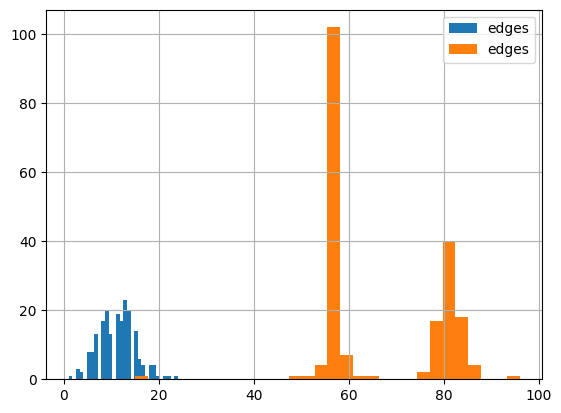

In [256]:
print(base_stats.groupby("community").mean())
print(synth_stats.groupby("community").mean())

base_stats.edges.hist(bins=30, legend=True)
synth_stats.edges.hist(bins=30, legend=True)

## ************************* Plotting *****************************

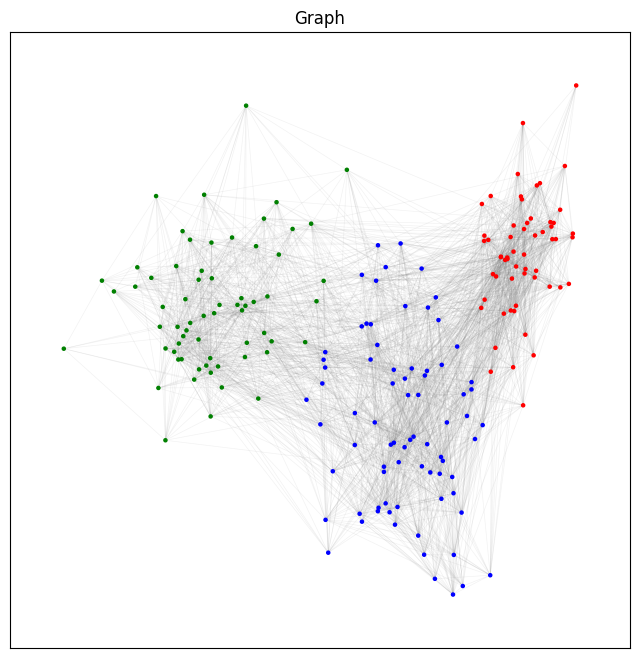

In [134]:
n_nodes = 200
gglm = gen_graph(n_nodes)
features = gglm.num_features #np.random.rand(n_nodes, 2)
categories = gglm.community_labels

G = gglm.Nx
node_idx = list(range(n_nodes))

# Assign 2D position to each node based on features
for i in node_idx:
    G.nodes[i]['pos'] = features[i]
    G.nodes[i]['category'] = categories[i]


# Extract positions
pos = {node: data['pos'] for node, data in G.nodes(data=True)}
color_map = {0: 'red', 1: 'green', 2: 'blue'}

node_colors = [color_map[G.nodes[i]['category']] for i in G.nodes()]


plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=.5, alpha=.1)

plt.title('Graph')
plt.axis('on')  
plt.show()

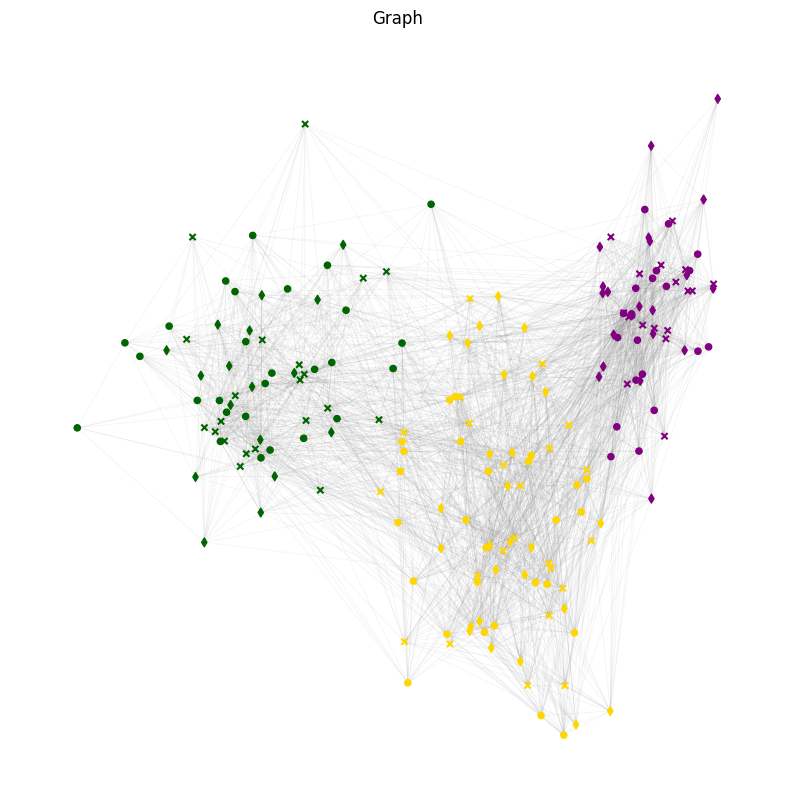

In [139]:
n_nodes = 200
features = gglm.num_features 
categories = gglm.community_labels 
target = np.random.randint(0, 3, size=n_nodes)

G = gglm.Nx
node_idx = list(range(n_nodes))

# Assign 2D position to each node based on features
for i in node_idx:
    G.nodes[i]['pos'] = features[i]
    G.nodes[i]['category'] = categories[i]
    G.nodes[i]['target'] = target[i]

pos = {node: data['pos'] for node, data in G.nodes(data=True)}
color_map = {0: 'purple', 1: 'darkgreen', 2: 'gold', 3: "black", 4:"silver"} # add more, for higher k 
shape_map = {0: 'x', 1: 'o', 2: "d", 3: "d"} #

plt.figure(figsize=(10, 10))
for shape in shape_map:
    nodelist = [node for node in G.nodes() if G.nodes[node]['target'] == shape]
    node_colors = [color_map[G.nodes[node]['category']] for node in nodelist]
    nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=node_colors, node_size=20, node_shape=shape_map[shape])

nx.draw_networkx_edges(G, pos, edge_color='gray', width=.5, alpha=.1)

plt.title('Graph')
plt.axis('off')  
plt.show()